# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

系统找不到指定的路径。


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Jan_28_19:41:49_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.142
Build cuda_11.2.r11.2/compiler.29558016_0


In [ ]:
#https://walkwithfastai.com/Segmentation

In [3]:
!pip install fastai

  Using cached fastai-2.7.11-py3-none-any.whl (232 kB)
     ---------------------------------------- 1.2/1.2 MB 7.6 MB/s eta 0:00:00
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
     -------------------------------------- 162.5/162.5 MB 8.5 MB/s eta 0:00:00
     --------------------------------------- 12.2/12.2 MB 11.5 MB/s eta 0:00:00
  Using cached fastcore-1.5.28-py3-none-any.whl (67 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl (12 kB)
     ---------------------------------------- 1.5/1.5 MB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 11.6 MB/s eta 0:00:00
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
     ---------------------------------------- 96.8/96.8 kB ? eta 0:00:00
  Using cached wasabi-1.1.1-py3-none-any.whl (27 kB)
  Using cached l

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.


In [ ]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
from fastai.vision.all import *

In [5]:
# import torch

torch.cuda.is_available()

True

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## 2. Preparing the data

---



In [2]:
path = Path('../')
path.ls()

(#15) [Path('../.gitignore'),Path('../.pytest_cache'),Path('../.vscode'),Path('../codes.txt'),Path('../images'),Path('../labels'),Path('../models'),Path('../orig_colorLabels'),Path('../orig_images'),Path('../orig_images_unlabled_Part01')...]

In [3]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved',
       'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'],
      dtype='<U12')

In [6]:
path_lbl = path/'labels'
path_im = path/'images'

In [9]:
fnames = get_image_files(path_im)
fnames[:3]
len(fnames)

701

In [10]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

701

<AxesSubplot:>

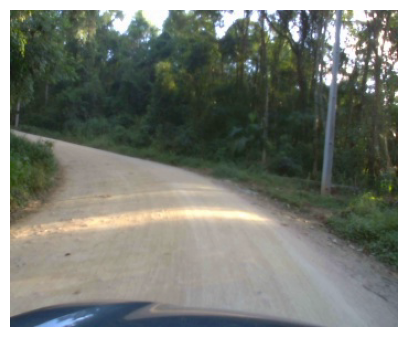

In [8]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [13]:
get_msk = lambda o: path/'labels'/f'{o.stem}{o.suffix}'

<AxesSubplot:>

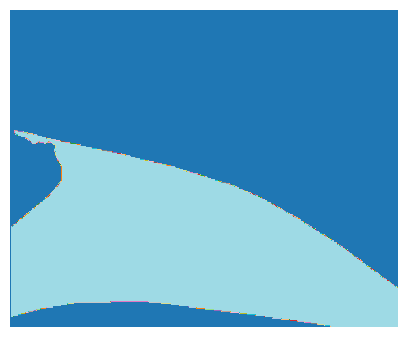

In [14]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [18]:
sz = msk.shape; sz

(288, 352)

In [19]:
half = tuple(int(x/2) for x in sz); half

(144, 176)

In [20]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [21]:
data = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [23]:
dls = data.dataloaders(path/'images', bs=4)

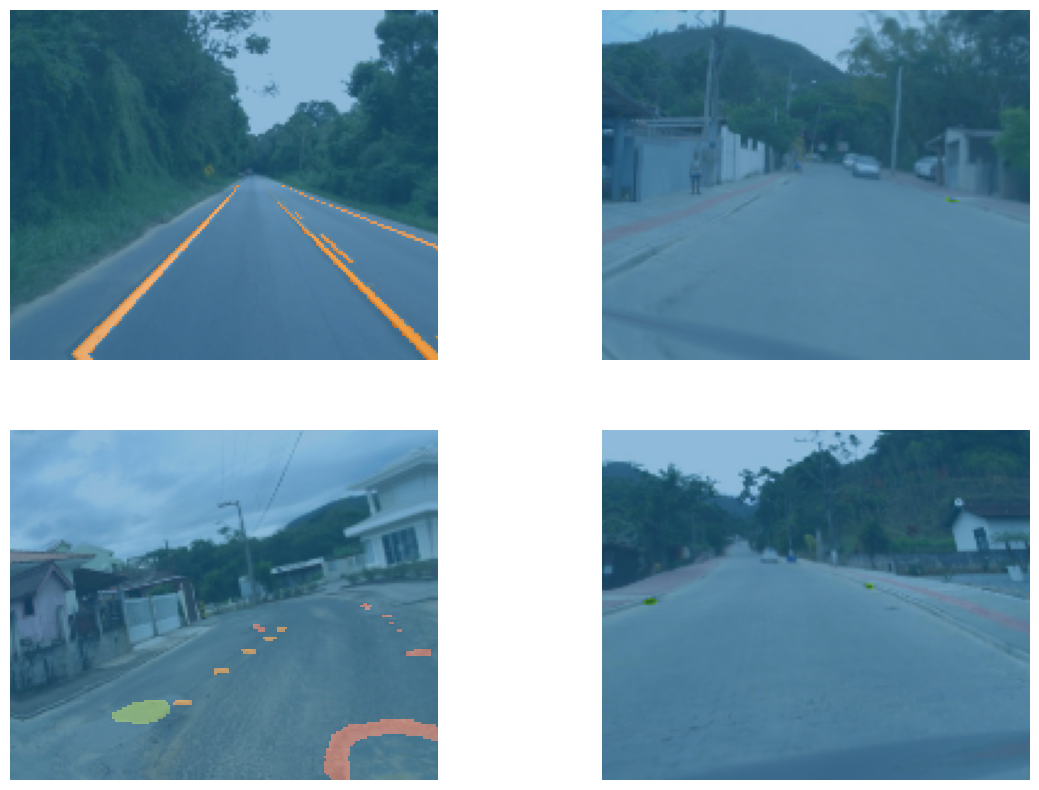

In [24]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [25]:
dls.vocab = codes

In [26]:
name2id = {v:k for k,v in enumerate(codes)};name2id

{'background': 0,
 'roadAsphalt': 1,
 'roadPaved': 2,
 'roadUnpaved': 3,
 'roadMarking': 4,
 'speedBump': 5,
 'catsEye': 6,
 'stormDrain': 7,
 'manholeCover': 8,
 'patchs': 9,
 'waterPuddle': 10,
 'pothole': 11,
 'craks': 12}

In [36]:
void_code = name2id['manholeCover']
def acc_test(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

### 3.2. First step Model

---



In [29]:
opt = ranger

In [30]:
learn = unet_learner(dls, resnet34, metrics=acc_test, self_attention=True, act_cls=Mish, opt_func=opt)

C:\Users\99609\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\99609\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=9.120108734350652e-05)

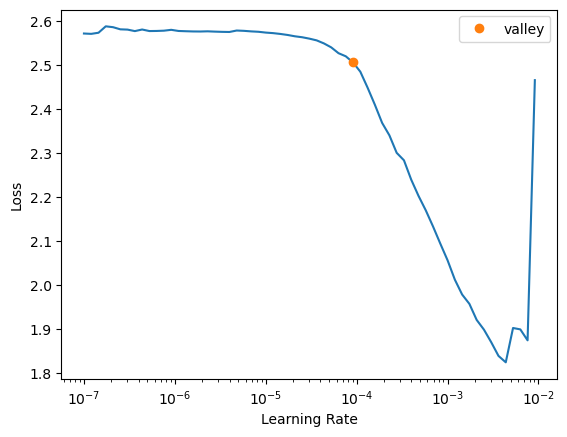

In [32]:
#CUDA_LAUNCH_BLOCKING=1
learn.lr_find()
# learn.recorder.plot()

In [34]:
lr=1e-4

In [37]:
learn.fit_flat_cos(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.310731,0.293963,0.906637,00:22
1,0.225529,0.203377,0.937284,00:23
2,0.195646,0.176200,0.944800,00:24
3,0.171807,0.162134,0.949526,00:25
4,0.154201,0.166144,0.945689,00:26
5,0.129759,0.136093,0.956455,00:26
6,0.117185,0.141101,0.954696,00:26
7,0.117387,0.127102,0.957548,00:26
8,0.109307,0.121640,0.961284,00:26
9,0.084537,0.105706,0.965192,00:26


In [38]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [39]:
learn.load('stage-1');

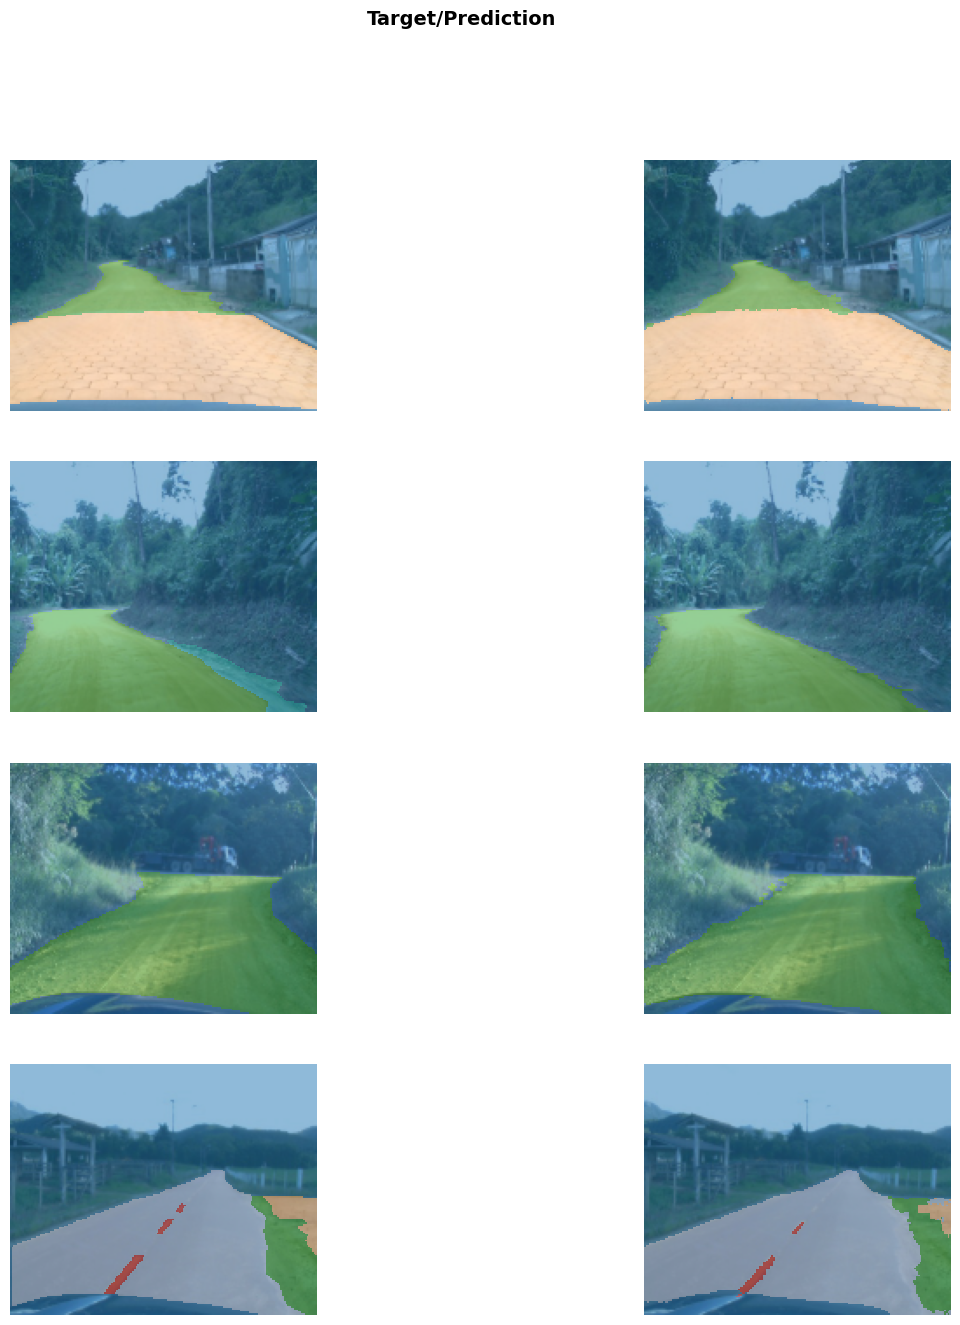

In [41]:
learn.show_results(max_n=4, figsize=(15,15))

### 3.3. Interpret

---



In [50]:
interp = SegmentationInterpretation.from_learner(learn)

In [52]:
top_losses, top_idxs = interp.top_losses()

(array([69., 30., 16.,  8.,  6.,  2.,  1.,  3.,  1.,  0.,  1.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01472559, 0.05117638, 0.08762717, 0.12407795, 0.16052875,
        0.19697952, 0.23343031, 0.2698811 , 0.3063319 , 0.34278268,
        0.37923345, 0.41568425, 0.45213503, 0.48858583, 0.52503663,
        0.5614874 , 0.5979382 , 0.634389  , 0.6708398 , 0.70729053,
        0.74374133], dtype=float32),
 <BarContainer object of 20 artists>)

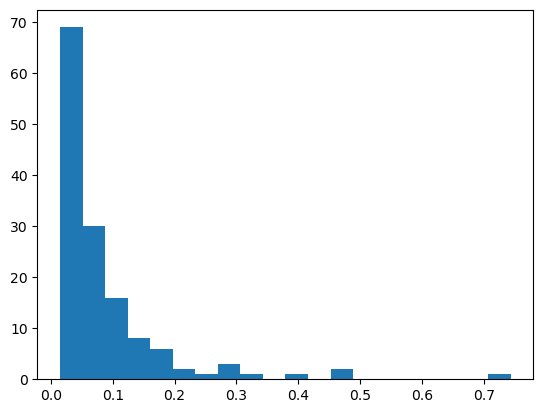

In [53]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

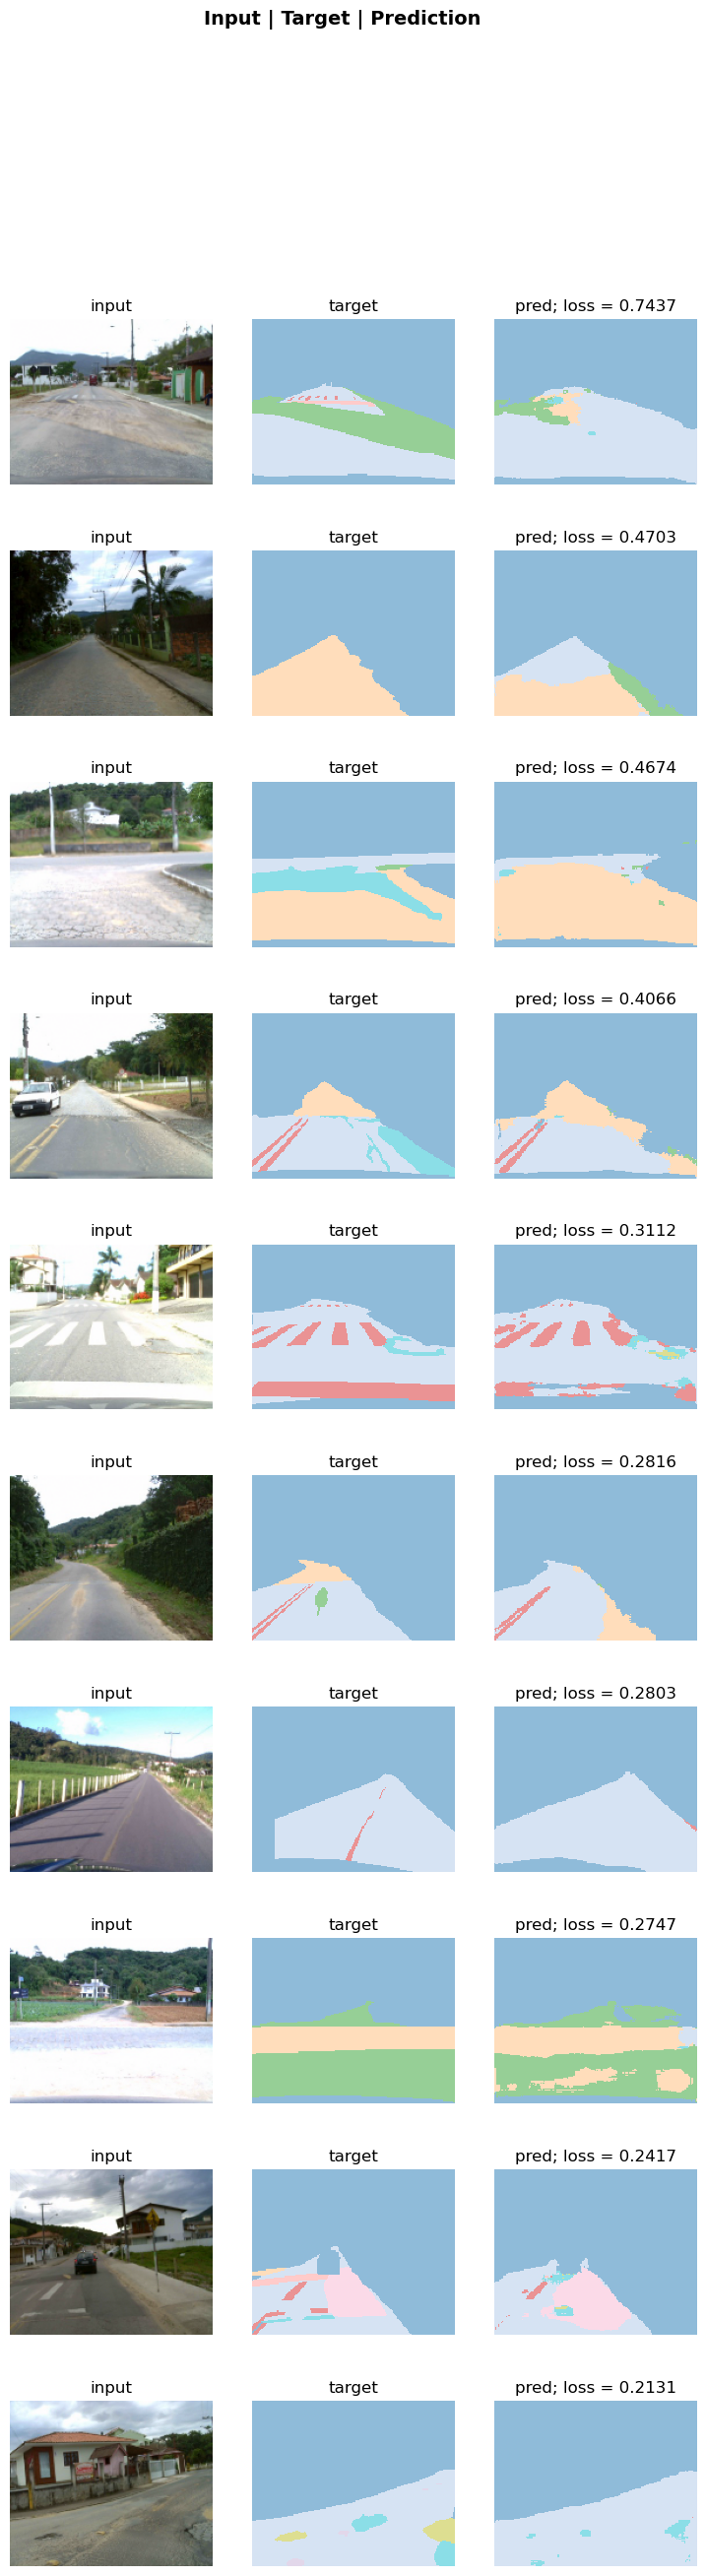

In [56]:
interp.plot_top_losses(10)

In [54]:
# top loss idxs of images
top_idxs[:5]

TensorBase([139, 116, 134, 135,  14])

### 3.5. First model continuation

---



In [42]:
learn.unfreeze()

In [43]:
lrs = slice(lr/400,lr/4)

In [44]:
learn.fit_flat_cos(12, lrs, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.084245,0.103877,0.965279,00:24
1,0.076228,0.099602,0.966770,00:25
2,0.074392,0.096207,0.967652,00:26
3,0.070086,0.094930,0.969204,00:27
4,0.072958,0.091345,0.969615,00:27
5,0.073066,0.093580,0.968502,00:27
6,0.066125,0.090543,0.969505,00:28
7,0.070331,0.091771,0.968708,00:28
8,0.070239,0.087348,0.970187,00:28
9,0.065639,0.089385,0.969940,00:28


In [45]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [46]:
learn.load('stage-2');

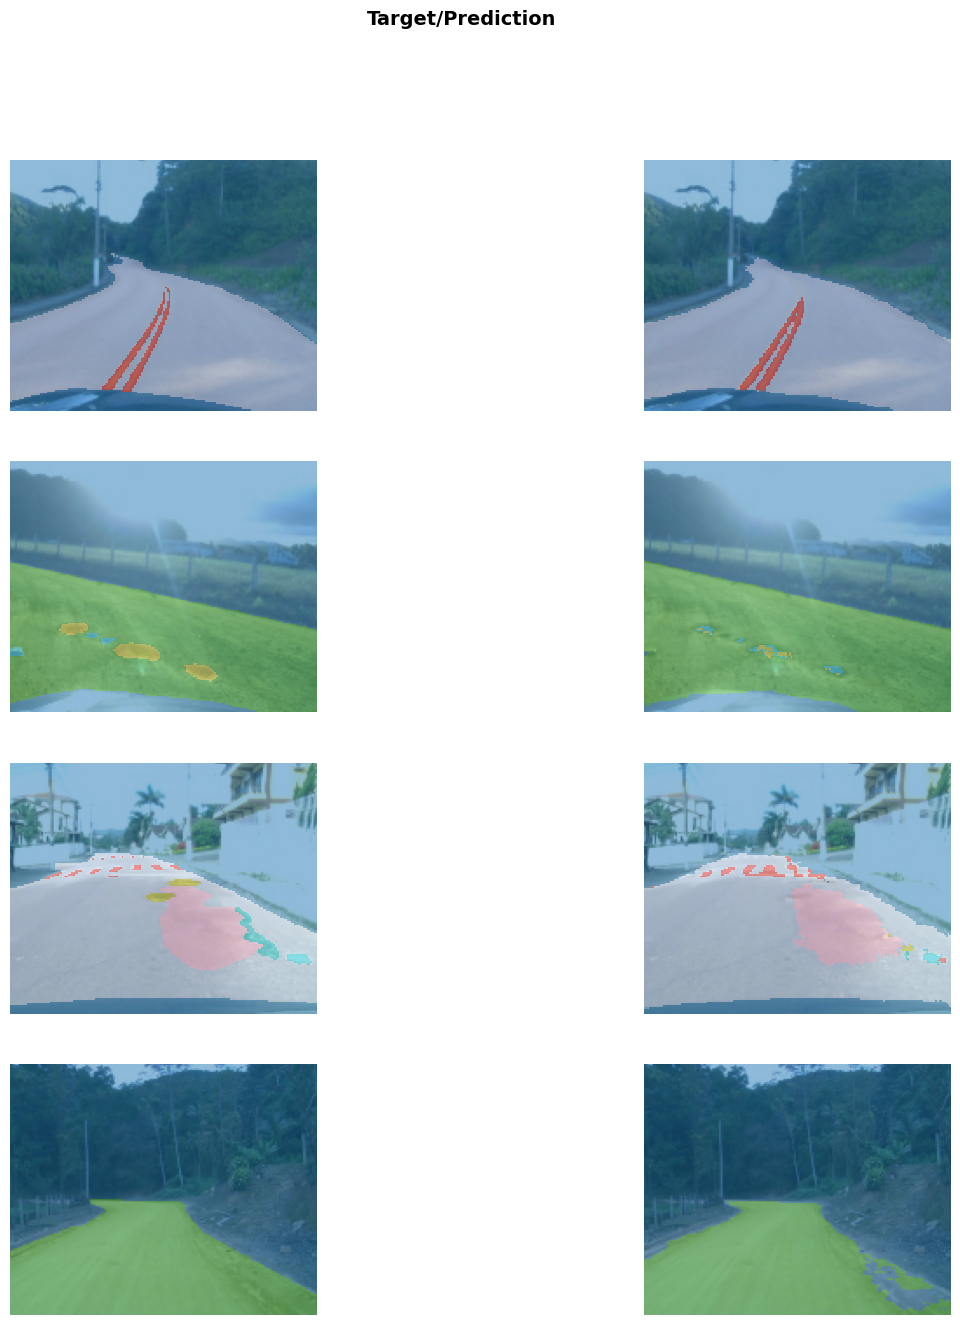

In [47]:
learn.show_results(max_n=4, figsize=(15,15))

## 4. Second Step - With weights

---



### 4.1. Second step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,10))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 4.2. Second step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [ ]:
learn.load('stage-2')

In [ ]:
!/opt/bin/nvidia-smi

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1-weights')

In [ ]:
learn.load('stage-1-weights');

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 4.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((288,352))

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

### 4.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.5. Second model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2-weights')

In [ ]:
learn.load('stage-2-weights');

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 4.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.7. Interpret

---



In [ ]:
learn.interpret

### 4.8. Saving

---



In [ ]:
learn.save('stage-2-weights')

## 5. Using a saved model to Predict

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34)

In [ ]:
learn.load('stage-2-weights');

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

In [ ]:
learn.show_results()

## 6. Saving the Results

---



In [ ]:
img_f = fnames[655]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
prediction = learn.predict(img)

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [ ]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        img_split = img_split[44:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [ ]:
save_preds(fnames)

## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")